<a href="https://colab.research.google.com/github/monmon2003/PyTorch/blob/main/style_transfer_pytorch_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import save_image

### 1. Loading the pretrained VGG19 model from `torchvision.models`

The VGG19 model has 3 components:
1. The feature holds all the conv, maxpool and ReLU layers
2. Average holds the average pool layer
3. Classifier holds the dense layers

We will be using only the CNN to implement style transfer, therefore we will import VGG19 features only.

In [2]:
# Loading the VGG19 model
model = models.vgg19(pretrained=True).features

# Setting up the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 108MB/s]


'cuda'

### 2. Creating a function to load the image and perform preprocessing

In [3]:
def image_loader(path):
  image=Image.open(path)

  # defining the transforms
  transform = transforms.Compose([
      transforms.Resize(size=(512,512)),
      transforms.ToTensor()
  ])

  # Changing the dimension of the image from (3, 512, 512) -> (1, 3, 512, 512)
  image = transform(image).unsqueeze(dim=0)
  return image.to(device, torch.float)

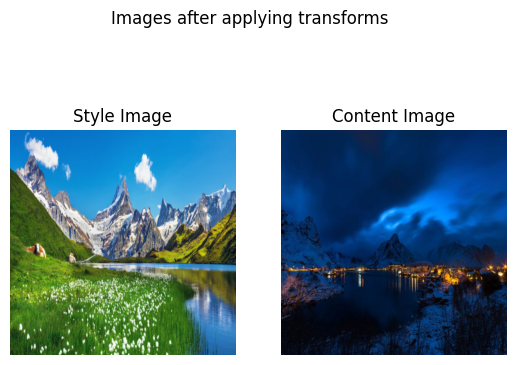

In [5]:
# Get the content image and the style image paths
orig_image_path = '/content/day_img.jpg'
style_image_path = '/content/night_img.jpg'

# Transform the images
c_image = image_loader(orig_image_path)
s_image = image_loader(style_image_path)

# Creating a function to visualize the content and style images
import matplotlib.pyplot as plt

def plot_images(c_image: torch.Tensor, s_image: torch.Tensor):
  fig, ax = plt.subplots(nrows=1, ncols=2)
  img1 = c_image[0].permute(1,2,0).to("cpu")
  ax[0].imshow(img1)
  ax[0].set_title("Style Image")
  ax[0].axis(False)

  img2 = s_image[0].permute(1,2,0).to("cpu")
  ax[1].imshow(img2)
  ax[1].set_title("Content Image")
  ax[1].axis(False)

  fig.suptitle("Images after applying transforms")
plot_images(c_image=c_image, s_image=s_image)

In [6]:
# Creating the base for the generated image from the content image
generated_img = c_image.clone().requires_grad_(True)

### 3. Building the VGG Model

We need only 5 layers in the model so we will be dropping the rest of the layers

In [7]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.req_features = ['0', '5', '10', '19', '28']
    self.model = models.vgg19(pretrained=True).features[:29] # model will contain the first 29 layers

  def forward(self,x):
    # Initialize an array that will hold the activations from the chosen layers
    features=[]
    # Iterate over all the layers
    for layer_num, layer in enumerate(self.model):
      # Activation of the layer will be stored in x
      x=layer(x)
      # Appending the activation of the selected layers and return the feature array
      if (str(layer_num) in self.req_features):
        features.append(x)

    return features



### 4. Defining the loss functions

In [8]:
# creating a function to calculate the content loss
def content_loss(generated_features, original_features):
  content_l = torch.mean((generated_features-original_features)**2)
  return content_l

# Creating a function for calculating the style loss
def style_loss(gen_img, style_img):
  batch_size, channel, height, width = gen_img.shape

  G = torch.matmul(gen_img.view(channel, height*width), gen_img.view(channel, height*width).T)
  A = torch.matmul(style_img.view(channel, height*width), style_img.view(channel, height*width).T)

  # Calculating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
  style_l = torch.mean((G-A)**2)
  return style_l

In [9]:
def total_loss(generated_features, original_features, style_features, alpha, beta):
  style_l , content_l = 0, 0
  for gen, content, style in zip(generated_features, original_features, style_features):
    content_l += content_loss(gen, content)
    style_l += style_loss(gen, style)

  # total loss for each epoch
  total_l = alpha*content_l + beta*style_l
  return total_l

### 5. Training the model

In [12]:
from tqdm.auto import tqdm

model_0 = VGG().to(device)

EPOCHS = 2000
alpha = 8
beta = 90
lr = 0.008
optimizer = torch.optim.Adam([generated_img], lr=lr)

model_0.eval()

for epoch in tqdm(range(EPOCHS)):
  gen_features = model_0(generated_img)
  orig_features = model_0(c_image)
  style_features = model_0(s_image)

  loss = total_loss(gen_features, orig_features, style_features,alpha=alpha,beta=beta)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print(f"Loss: {loss}")

    save_image(generated_img, "gen.png")

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss: 2051254.625
Loss: 4021834.25
Loss: 2796399.75
Loss: 2369207.5
Loss: 2126165.25
Loss: 1962126.25
Loss: 1841894.5
Loss: 1747931.5
Loss: 1666228.875
Loss: 1614642.0
Loss: 6969946.0
Loss: 2015526.25
Loss: 1728359.5
Loss: 1580163.25
Loss: 1486113.125
Loss: 1407180.5
Loss: 1343964.5
Loss: 1309318.375
Loss: 1286814.375
Loss: 1234119.625


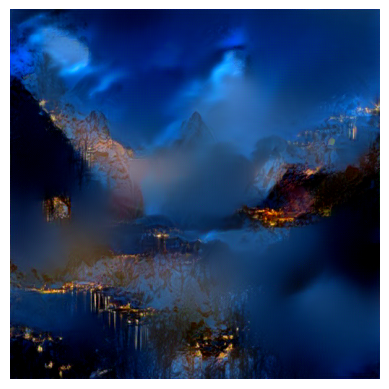

In [15]:
# After 6000 epochs
generated_img_path = '/content/gen.png'
gen_img = Image.open(generated_img_path)
plt.imshow(gen_img)
plt.axis('off')
plt.show()